In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error


In [56]:
symbol = "ADAUSDT"

ADAData = pd.read_csv(f"./preparedData/{symbol}.csv", date_parser = True)
ADAData.head()

,open_time,open,high,low,close,volume,close_time
0,2018-05-01 05:30:00,0.34145,0.34199,0.31870,0.32173,32463784.08,2018-05-01 09:29:59
1,2018-05-01 09:30:00,0.32115,0.34300,0.32000,0.33787,14470581.61,2018-05-01 13:29:59
2,2018-05-01 13:30:00,0.33756,0.35900,0.33421,0.34093,25321414.19,2018-05-01 17:29:59
3,2018-05-01 17:30:00,0.34003,0.34290,0.33166,0.33735,16675168.68,2018-05-01 21:29:59
4,2018-05-01 21:30:00,0.33776,0.35950,0.33714,0.35374,18237446.69,2018-05-02 01:29:59


In [57]:
# close column of the data
close = ADAData['close']

# number of rows in data
data_shape = close.shape
rows = data_shape[0]

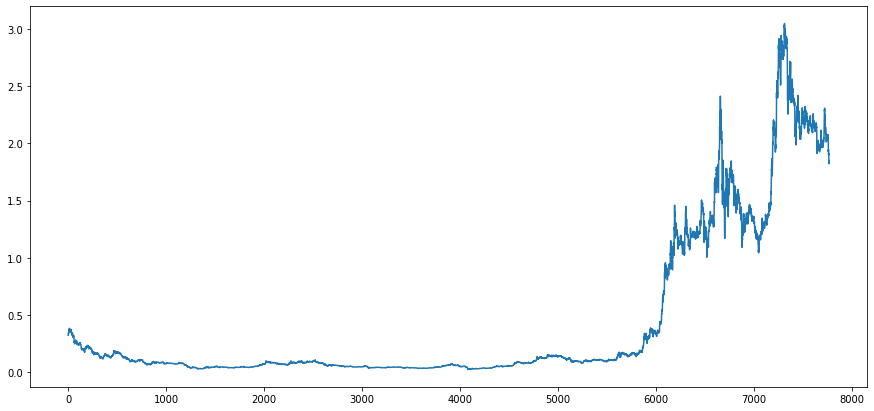

In [145]:
# plot of close price movement over the time period
plt.figure(figsize=(15, 7))
plt.plot(close)
plt.show()

In [59]:
# Normalization
# MinMaxScaler is used to normalize the data
# LSTM are sensitive to the scale of the data.

scaler = MinMaxScaler(feature_range=(0,1))
normalized_data = scaler.fit_transform(np.array(close).reshape(-1,1))
print(normalized_data)
print("Shape : ", normalized_data.shape)

[[0.0989652 ]
 [0.10429949]
 [0.10531082]
 ...
 [0.59612785]
 [0.60372937]
 [0.59546685]]
Shape :  (7770, 1)


In [60]:
# data train
data_train = normalized_data[ :math.floor(rows*0.8) , : ]

# data test
data_test = normalized_data[ math.floor(rows*0.8): , : ]

print(data_train.shape)
print(data_test.shape)

(6216, 1)
(1554, 1)


In [61]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [62]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, Y_train = create_dataset(data_train, time_step)
X_test, Y_test = create_dataset(data_test, time_step)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(6115, 100) (6115,)
(1453, 100) (1453,)


In [63]:
# reshape input to be [samples, time steps, features] 
# which is required for LSTM
# basically 3-D data is required as input to LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [67]:
# added basic properties of LSTM model
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1] ,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [68]:
# fitting training and test data into the model.
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
96/96 [==============================] - 23s 183ms/step - loss: 2.1005e-04 - val_loss: 0.0036
Epoch 2/100
96/96 [==============================] - 16s 171ms/step - loss: 5.5848e-05 - val_loss: 0.0050
Epoch 3/100
96/96 [==============================] - 17s 178ms/step - loss: 5.0963e-05 - val_loss: 0.0076
Epoch 4/100
96/96 [==============================] - 16s 172ms/step - loss: 4.2817e-05 - val_loss: 0.0027
Epoch 5/100
96/96 [==============================] - 16s 163ms/step - loss: 3.1539e-05 - val_loss: 0.0017
Epoch 6/100
96/96 [==============================] - 17s 173ms/step - loss: 3.6945e-05 - val_loss: 0.0030
Epoch 7/100
96/96 [==============================] - 15s 154ms/step - loss: 3.4252e-05 - val_loss: 0.0029
Epoch 8/100
96/96 [==============================] - 15s 154ms/step - loss: 3.2343e-05 - val_loss: 0.0013
Epoch 9/100
96/96 [==============================] - 14s 148ms/step - loss: 3.5818e-05 - val_loss: 0.0019
Epoch 10/100
96/96 [==========================

In [69]:
# Now performing the prediction and check performance metrics

predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

In [70]:
# Transformback the data to original form

predict_train = scaler.inverse_transform(predict_train)
predict_test = scaler.inverse_transform(predict_test)

In [75]:
# Calculating RMSE performance metrics
# for training data
print("RMSE for training data : ", math.sqrt(mean_squared_error(Y_train, predict_train)))

# for test data
print("RMSE for test data : ",math.sqrt(mean_squared_error(Y_test, predict_test)))

RMSE for training data :  0.13449336488131972
RMSE for test data :  1.2314203907921928


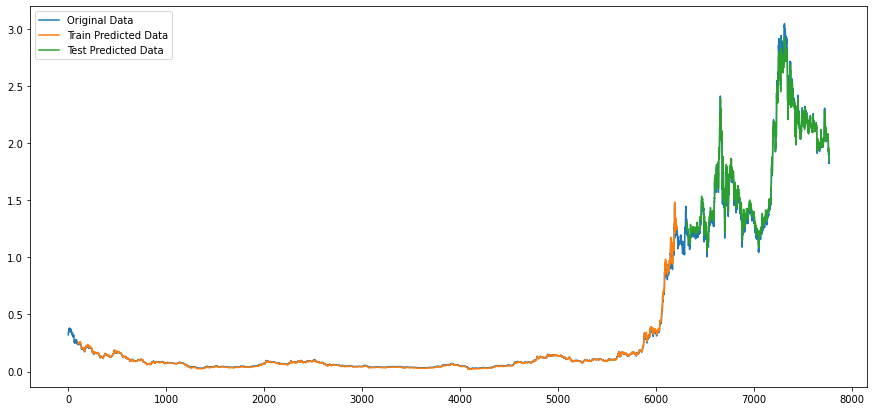

In [144]:
# Plotting 
# shift train predictions for plotting
look_back = time_step
trainPredictPlot = np.empty_like(normalized_data)
trainPredictPlot[ :, : ] = np.nan
trainPredictPlot[ look_back:len(predict_train)+look_back, : ] = predict_train

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_data)
testPredictPlot[ :, : ] = np.nan
testPredictPlot[len(predict_train)+(look_back*2)+1 : len(normalized_data)-1 , : ] = predict_test

# plot baseline and predictions
plt.figure(figsize=(15, 7))
plt.plot(scaler.inverse_transform(normalized_data), label="Original Data")
plt.plot(trainPredictPlot, label="Train Predicted Data")
plt.plot(testPredictPlot, label="Test Predicted Data")
plt.legend()
plt.show()

In [147]:
# now predicting for next 30 days.
# for which we will be required the data of last 100 days
# which will we get from data_test(last 100 records)

X_input_2d = data_test[len(data_test)-time_step : ].reshape(1, -1)

# converting the 100 days data to a list
X_input_list = X_input_2d[0].tolist()


In [148]:
# Now finding the prediction for next 30 days

n_steps = time_step
X_output_2d = []

i=0
while(i<30):
    if( len(X_input_list) > 100 ):

        # removing 1st data from list and reshaping array to 2-D
        X_input_2d = np.array(X_input_list[1 : ]).reshape(1,-1)  

        # reshaping array to 3-D for model prediction 
        X_input_3d = X_input_2d.reshape((1, n_steps, 1))         

        X_output_3d = model.predict(X_input_3d)

        X_input_list.extend(X_output_3d[0].tolist())
        X_input_list = X_input_list[1 : ]

        X_output_2d.extend(X_output_3d.tolist())

    else:
        X_input_3d = X_input_2d.reshape((1, n_steps, 1))
        X_output_3d = model.predict(X_input_3d)

        X_input_list.extend(X_output_3d[0].tolist())
        X_output_2d.extend(X_output_3d.tolist())
    i=i+1

print(X_output_2d)

[[0.6035630106925964], [0.6123474836349487], [0.620593249797821], [0.6279870271682739], [0.6342124342918396], [0.6393477916717529], [0.6436434984207153], [0.6473811864852905], [0.6507883667945862], [0.6540048122406006], [0.6570849418640137], [0.660020649433136], [0.6627713441848755], [0.6652889251708984], [0.667535662651062], [0.6694928407669067], [0.6711623668670654], [0.6725631952285767], [0.6737251877784729], [0.6746841669082642], [0.6754758954048157], [0.6761342287063599], [0.6766884326934814], [0.677162766456604], [0.6775771379470825], [0.6779478192329407], [0.6782872676849365], [0.6786055564880371], [0.6789106726646423], [0.6792088150978088]]


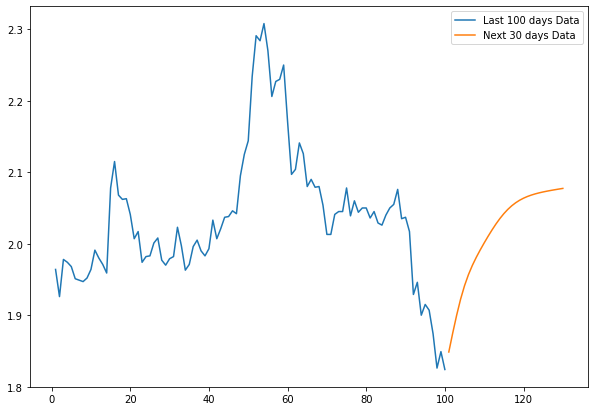

In [169]:
# now plotting the next 30 days data with previous 100 days data

day_last_100 = np.arange(1, time_step+1)
day_next_30 = np.arange(time_step+1, time_step+1+30)

plt.figure(figsize=(10, 7))
plt.plot(day_last_100, scaler.inverse_transform(data_test[len(data_test)-time_step : ]), label = "Last 100 days Data")
plt.plot(day_next_30, scaler.inverse_transform(X_output_2d), label = "Next 30 days Data")
plt.legend()
plt.show()

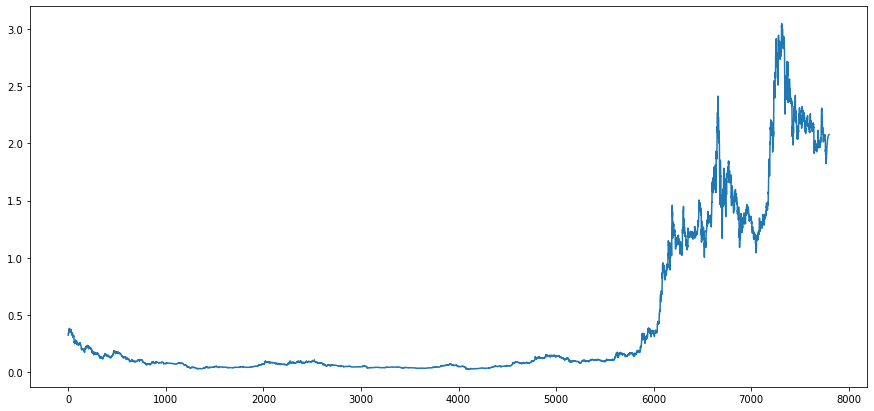

In [168]:
old_data = normalized_data.tolist()
old_data.extend(X_output_2d)
plt.figure(figsize=(15, 7))
plt.plot(scaler.inverse_transform(old_data))
plt.show()